In [1]:
# SGD -> Adam
# dropout -> 0.2
# dropout to Z
# pretraining lr -> 0.001
# weight decay -> 0.001
# epoch 1000 to pretrain
# batch wise pretraining
# gpu enabled

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import ast
import torch.optim as optim
import csv
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Read the prototypes CSV file
df = pd.read_csv('/kaggle/input/transformer-instances-with-prototypes/zero_to_fifty/prototypes_3.csv')
df1 = pd.read_csv('/kaggle/input/transformer-instances-with-prototypes/gsl_zero_to_fifty_three/prototypes_3.csv')

# Convert to a dictionary
ssl_prototypes = pd.Series(df['feature'].values,index=df['label']).to_dict()
gsl_prototypes = pd.Series(df1['feature'].values,index=df1['label']).to_dict()


# Read train data CSV file
# df_train = pd.read_csv('/kaggle/input/transformer-instances-with-prototypes/zero_to_fifty/ssl-n-way-k-shot_train_3.csv')

# Evaluate string representations of Python literals
ssl_prototypes = {k: ast.literal_eval(v) for k, v in ssl_prototypes.items()}
gsl_prototypes = {k: ast.literal_eval(v) for k, v in gsl_prototypes.items()}

In [4]:
class STFE(nn.Module): # Salient Temporal Feature Extractor
    def __init__(self, d, d_prime, d_double_prime):
        super(STFE, self).__init__()
        # Initialize learnable parameters with appropriate layers
        self.W_X = nn.Linear(d_prime, d)
        self.W_M = nn.Linear(d_prime, d)
        self.W_delta = nn.Linear(d_prime, d)
        self.W_u = nn.Linear(d, d_prime)
        self.W_P = nn.Linear(d_double_prime, d)
        self.W_Q = nn.Linear(d_double_prime, d)
        self.W_V = nn.Linear(d_double_prime, d)
        self.W_O = nn.Linear(d, d_double_prime)
        self.fc = nn.Linear(d, 54)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, M):
        # Define forward function
        r = torch.softmax(X @ self.W_X.weight @ (M @ self.W_M.weight).t(), dim=1)
        U = r @ (M @ (self.W_M.weight + self.W_delta.weight))
        Z = U @ self.W_u.weight + X
        Z = self.dropout(Z)  # Apply dropout after the activation function
        P = torch.max(Z, dim=0)[0]
        S = P @ self.W_P.weight @ (X @ self.W_Q.weight).t()
        A = torch.softmax(S, dim=0)
        V = self.fc(A @ (X @ self.W_V.weight @ self.W_O.weight))
        return V

In [5]:
# Define the dataset class
class SkeletonDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
ssl_sorted_prototypes = dict(sorted(ssl_prototypes.items()))
ssl_sorted_prototype_values = torch.tensor(list(ssl_sorted_prototypes.values()))
ssl_sorted_prototype_values = ssl_sorted_prototype_values.to(device)

gsl_sorted_prototypes = dict(sorted(gsl_prototypes.items()))
gsl_sorted_prototype_values = torch.tensor(list(gsl_sorted_prototypes.values()))
gsl_sorted_prototype_values = gsl_sorted_prototype_values.to(device)

# Pre-Training

In [7]:
values = []
matrix_labels = []
input_file = '/kaggle/input/gsl-matrix-file/gsl-padded_matrix_file.csv'
with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        
matrix_labels = np.array(matrix_labels)

train_values = torch.stack([value.clone().detach() for value in values])
train_matrix_labels = matrix_labels

In [8]:
# map classes to 0 to 49
adjusted_train_matrix_labels = train_matrix_labels.copy()
adjusted_train_values = train_values.clone()  # Use clone for PyTorch tensors
un_labels = np.unique(train_matrix_labels)

for i in range(len(un_labels)):
#     if i >= 50:
#         # indexes of adjusted_train_matrix_labels which has un_labels[i] should be removed from both adjusted_train_matrix_labels and adjusted_train_values
#         indices_to_remove = np.where(adjusted_train_matrix_labels == un_labels[i])[0].tolist()
#         adjusted_train_matrix_labels = np.delete(adjusted_train_matrix_labels, indices_to_remove)
#         adjusted_train_values = torch.stack([adjusted_train_values[i] for i in range(len(adjusted_train_values)) if i not in indices_to_remove])  # Use torch.stack for multi-dimensional tensors
#     else:
        adjusted_train_matrix_labels[adjusted_train_matrix_labels == un_labels[i]] = i

In [9]:
d = adjusted_train_values[0].shape[1]
d_prime = adjusted_train_values[0].shape[0]
d_doble_prime = adjusted_train_values[0].shape[0]

train_data, test_data, train_labels, test_labels = train_test_split(
    adjusted_train_values, torch.tensor(adjusted_train_matrix_labels), test_size=0.4, random_state=42, stratify=torch.tensor(adjusted_train_matrix_labels)
)

# validation_data, test_data, validation_labels, test_labels = train_test_split(
#     test_data, test_labels, test_size=0.5, random_state=42, stratify=test_labels
# )

In [42]:
# Create train, validation, and test datasets
train_dataset = SkeletonDataset(train_data, train_labels)
test_dataset = SkeletonDataset(test_data, test_labels)

pre_train_batch_size = 32

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=pre_train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=pre_train_batch_size, shuffle=False)

# Initialize the network

stfe = STFE(d, d_prime, d_doble_prime)
stfe.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(stfe.parameters(), lr=0.001, weight_decay=0.001)

train_losses = []
validation_losses = []

num_epochs = 1000

for epoch in range(num_epochs):  # loop over the dataset multiple times
    stfe.train()
    epoch_train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        for i in range(len(data)):  # loop over each element in data
            output = stfe(data[i], gsl_sorted_prototype_values)
            loss = criterion(output, labels[i])
            loss.backward()            
            epoch_train_loss += loss.item()
            
        optimizer.step()
        
    epoch_train_loss /= len(train_loader.dataset)
    
    train_losses.append(epoch_train_loss)
    
    # Calculate validation loss
    stfe.eval()
    epoch_validation_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            for i in range(len(data)):
                outputs = stfe(data[i], gsl_sorted_prototype_values)
                loss = criterion(outputs, labels[i])
                epoch_validation_loss += loss.item()
    epoch_validation_loss /= len(test_loader.dataset)
    validation_losses.append(epoch_validation_loss)  
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}")

    # Save the model
    torch.save(stfe.state_dict(), f"/kaggle/working/model_epoch_{epoch + 1}.pt")

# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/1000, Train Loss: 3.9821, Validation Loss: 3.9738
Epoch 2/1000, Train Loss: 3.9677, Validation Loss: 3.9453


KeyboardInterrupt: 

In [ ]:
torch.save(stfe.state_dict(), '/kaggle/working/pretrained_stfe.pt')

# Training & Evaluation

In [10]:
values = []
matrix_labels = []
input_file = '/kaggle/input/transformer-instances-with-prototypes/zero_to_fifty/ssl-n-way-k-shot_train.csv'
with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        
matrix_labels = np.array(matrix_labels)

train_values = torch.stack([value.clone().detach() for value in values])
train_matrix_labels = matrix_labels

In [11]:
# Your code for loading the data (unchanged)
input_file = "/kaggle/input/transformer-instances-with-prototypes/zero_to_fifty/ssl-n-way-k-shot_test.csv"

values = []
matrix_labels = []

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        
matrix_labels = np.array(matrix_labels)
test_values = torch.stack([value.clone().detach() for value in values])
test_matrix_labels = matrix_labels

In [14]:
# Concatenate along the first dimension (0)
all_values = torch.cat((train_values, test_values), 0)
all_labels = np.concatenate((train_matrix_labels, test_matrix_labels), axis=0)

train_data, test_data, train_labels, test_labels = train_test_split(
    all_values, torch.tensor(all_labels), test_size=0.2, random_state=42, stratify=torch.tensor(all_labels)
)
validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.7, random_state=42, stratify=test_labels
)

# Create train, validation, and test datasets
train_dataset = SkeletonDataset(train_data, train_labels)
validation_dataset = SkeletonDataset(validation_data, validation_labels)
test_dataset = SkeletonDataset(test_data, test_labels)

train_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=train_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=train_batch_size, shuffle=False)

In [38]:
len(train_data)

600

Epoch 1/1000, Train Loss: 3.7164, Validation Loss: 3.2407
Epoch 2/1000, Train Loss: 2.7337, Validation Loss: 2.3342
Epoch 3/1000, Train Loss: 2.1484, Validation Loss: 2.1188
Epoch 4/1000, Train Loss: 1.8867, Validation Loss: 1.9657
Epoch 5/1000, Train Loss: 1.6879, Validation Loss: 1.8887
Epoch 6/1000, Train Loss: 1.5966, Validation Loss: 1.7714
Epoch 7/1000, Train Loss: 1.4819, Validation Loss: 1.7204
Epoch 8/1000, Train Loss: 1.3772, Validation Loss: 1.6636
Epoch 9/1000, Train Loss: 1.2753, Validation Loss: 1.5970
Epoch 10/1000, Train Loss: 1.1962, Validation Loss: 1.5385
Epoch 11/1000, Train Loss: 1.1738, Validation Loss: 1.5247
Epoch 12/1000, Train Loss: 1.1668, Validation Loss: 1.5345
Epoch 13/1000, Train Loss: 1.1057, Validation Loss: 1.4335
Epoch 14/1000, Train Loss: 0.9945, Validation Loss: 1.4766
Epoch 15/1000, Train Loss: 0.9939, Validation Loss: 1.5138
Epoch 16/1000, Train Loss: 0.9678, Validation Loss: 1.3294
Epoch 17/1000, Train Loss: 0.9587, Validation Loss: 1.6142
Epoch 

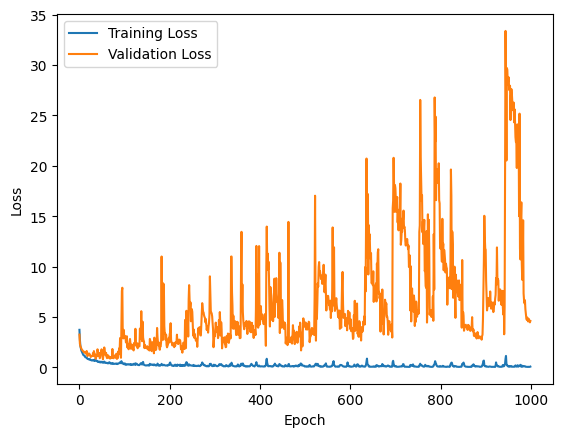

In [15]:
# Convert labels to tensor if they are numpy arrays
if isinstance(train_matrix_labels, np.ndarray):
    train_matrix_labels = torch.from_numpy(train_matrix_labels)
    
# Initialize the network
stfe = STFE(d, d_prime, d_doble_prime)
stfe.load_state_dict(torch.load('/kaggle/input/best-model/model_epoch_998.pt'))

# # Freeze all layers
# for param in stfe.parameters():
#     param.requires_grad = False

# Replace the last layer
stfe.fc = nn.Linear(d, 50)
stfe.to(device)
# # Unfreeze the last layer
# for param in stfe.fc.parameters():
#     param.requires_grad = True

# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(stfe.parameters(), lr=0.001, weight_decay=0.001)

train_losses = []
validation_losses = []

num_epochs = 100
# Training loop
for epoch in range(num_epochs):  # loop over the dataset multiple times
    stfe.train()
    epoch_train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        for i in range(len(data)):
        # forward + backward + optimize
            outputs = stfe(data[i], ssl_sorted_prototype_values)
            loss = criterion(outputs, labels[i])
            loss.backward()
            epoch_train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss /= len(train_loader.dataset)
    
    train_losses.append(epoch_train_loss)

    # Calculate validation loss
    stfe.eval()
    epoch_validation_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(validation_loader):
            data, labels = data.to(device), labels.to(device)
            for i in range(len(data)):
                outputs = stfe(data[i], ssl_sorted_prototype_values)
                loss = criterion(outputs, labels[i])
                epoch_validation_loss += loss.item()
    epoch_validation_loss /= len(validation_loader.dataset)
    validation_losses.append(epoch_validation_loss)  
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}")
    
    # Save the model
    torch.save(stfe.state_dict(), f"/kaggle/working/model_epoch_{epoch + 1}.pt")
        
# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [16]:
min(validation_losses)

0.7978744902900264

# Testing

In [13]:
# # Your code for loading the data (unchanged)
# input_file = "/kaggle/input/transformer-instances-with-prototypes/zero_to_fifty/ssl-n-way-k-shot_test.csv"

# values = []
# matrix_labels = []

# with open(input_file, "r") as f_input:
#     reader = csv.reader(f_input)
#     for row in reader:
#         row_values = []
#         for i in range(len(row) - 1):
#             column_value = ast.literal_eval(row[i])
#             row_values.append(column_value)
#         values.append(torch.tensor(row_values))
#         matrix_labels.append(ast.literal_eval(row[-1]))
        
# matrix_labels = np.array(matrix_labels)
# test_values = torch.stack([value.clone().detach() for value in values])
# test_matrix_labels = matrix_labels

In [15]:
len(test_values)

500

In [18]:
stfe = STFE(d, d_prime, d_doble_prime)
stfe.fc = nn.Linear(d, 50)
stfe.load_state_dict(torch.load('/kaggle/working/model_epoch_53.pt'))
stfe.to(device)

# test_batch_size = 16
# test_dataset = SkeletonDataset(test_values, test_matrix_labels)
# test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

# Put the model in evaluation mode
stfe.eval()

# Initialize the total loss and the number of correct predictions
total_loss = 0.0
total_correct = 0

# No need to track gradients during testing
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        
        for i in range(len(data)):
            # forward + backward + optimize
            outputs = net(data[i], ssl_sorted_prototype_values)
            loss = criterion(outputs, labels[i])
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 0)  # Get the predicted class
            
            # Count the number of correct predictions
            total_correct += (predicted == labels[i]).sum().item()

# Calculate the average loss and the accuracy over the entire test set
avg_loss = total_loss / len(test_loader.dataset)
accuracy = total_correct / len(test_loader.dataset)

print('Test Loss: %.3f' % avg_loss)
print('Test Accuracy: %.3f' % accuracy)

Test Loss: 1.428
Test Accuracy: 0.757
